# First Algorithm

This notebook introduces basic Coba functionality for contextual bandit learner research (i.e., algorithms).

## Creating a Learner

In Coba a contextual bandit learner is any class that implements the following interface.

```python
class Learner:
    @property
    def params(self) -> Dict[str,Hashable]:
        """(Optional) Return the hyperparameters for the learner."""
    def score(self, context: Context, actions: Sequence[Action], action:Action) -> float:
        """(Optional) Return the propensity score for the given action."""
    def predict(self, context: Context, actions: Sequence[Action]) -> Action | Tuple[Action,float]:
        """Choose which action to take."""
    def learn(self, context: Context, action: Action, reward: Reward, probability: float, **kwargs) -> None:
        """Learn from the results of an action in a context.""""
```

For example, below we define a new learner that we call `MyRandom` which we will demonstrate how to evaluate in this notebook.

In [4]:
import coba as cb

class MyRandom:
    def __init__(self,seed):
        self._rng = cb.CobaRandom(seed)
    @property
    def params(self):
        return {"seed": self._rng.seed}
    def score(self, context, actions, action) -> float:
        return 1/len(actions)
    def predict(self, context, actions):
        return self._rng.choice(actions)
    def learn(self, context, action, reward, probability):
        pass

## Validating MyRandom

Using Coba's synthetic datasets and baseline learners we can quickly validate that our learner is working as expected. To do this:
+ We create a simple linear environment with a single context feature.
+ We compare our learner's performance to a RandomLearner (learners learning anything should beat this)
+ We compare our learner's perofmrnace to a BanditUCBLearner (learners using context features should beat this)

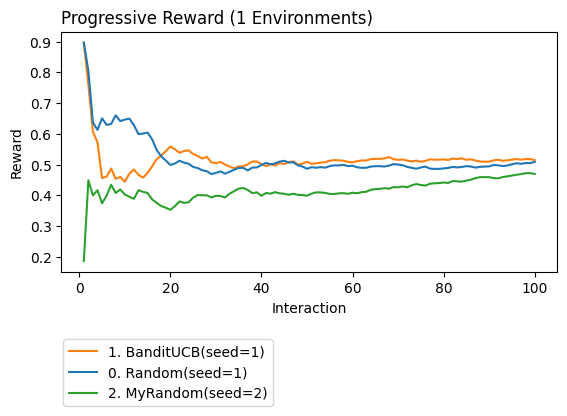

In [5]:
import coba as cb

env = cb.Environments.from_linear_synthetic(n_interactions=100, n_context_features=1, n_action_features=0, n_actions=5, seed=3)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), MyRandom(seed=2) ]

cb.Experiment(env,lrn).run(quiet=True).plot_learners()

We expected `MyRandom` to perform the same as `cb.RandomLearner` and worse than `cb.BanditUCBLearner`.

What we actually see above is that `MyRandom` did worse than both `cb.RandomLearner` and `cb.BanditUCBLearner`.

It seems plausible that `MyRandom` is doing worse due to chance. We make two changes to our experiment to rule this out:
1. We set `n_interactions` to `500` instead of `100`. This will give `cb.BanditUCBLearner` more time to learn.
2. We add `shuffle(n=10)` to our environment to create 10 shuffled copies. This is the coba equivalent of `sklearn.model_selection.RepeatedKFold`.


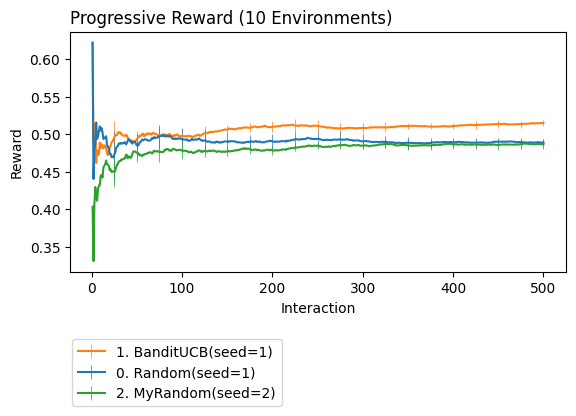

In [8]:
import coba as cb

#Increased the number of interactions to 500 and created 10 shuffled copies of our environment
env = cb.Environments.from_linear_synthetic(n_interactions=500, n_context_features=1, n_action_features=0, n_actions=5,seed=3).shuffle(n=10)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), MyRandom(seed=2) ]

cb.Experiment(env,lrn).run(quiet=True).plot_learners(err='bs')

With those two changes we now we see what we expected: 
+ `MyRandom` is performing similarly to `cb.RandomLearner`. 
+ `MyRandom` is performing worse than `cb.BanditUCBLearner`.

This outcome is merely meant as an example. In practice, had `MyRandom` been an actual contextual bandit algorithm it should have beaten both `cb.RandomLearner` and `cb.BanditUCBLearner`. To demonstrate how a real contextual bandit algorithm performs we repeat example using `cb.VowpalEpsilonLearner` instead of `MyRandom`.

## Real Learner Performance

The toy learner we made above obviously wasn't going to do well since it just randomly selected actions. 

How about if we use a real linear contextual bandit learner? Does it outperform both the `cb.RandomLearner` and `cb.BanditUCBLearner`?

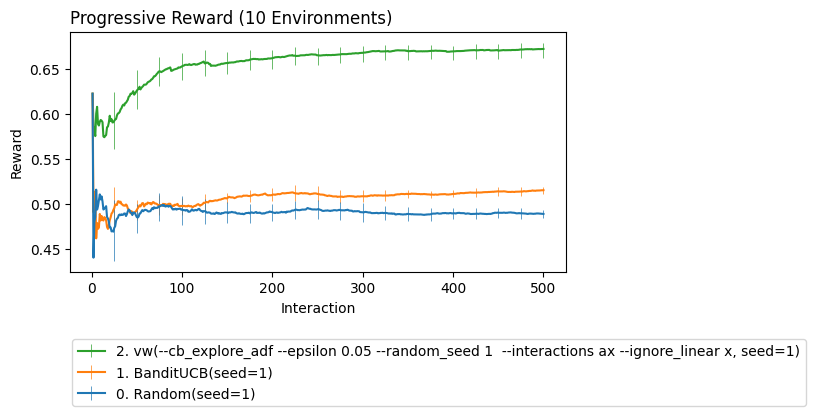

In [9]:
import coba as cb

env = cb.Environments.from_linear_synthetic(n_interactions=500, n_context_features=1, n_action_features=0, n_actions=5,seed=3).shuffle(n=10)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), cb.VowpalEpsilonLearner(features=(1,'a','ax')) ]

cb.Experiment(env,lrn).run(quiet=True).plot_learners(err='bs')

## Real-Data Experiment

The `cb.VowpalEpsilonLearner` looks good on the synthetic dataset. We are now ready to see how it performs on real-world datasets.

For this experiment we're going to do the following:
1. Use the [Feurer benchmark](https://jmlr.org/papers/v23/21-0992.html) to download 247 classification datasets from openml, which coba will turn into contextual bandit environments. 
2. Save the results of our experiment to disk in case we want to look at them again later or resume the experiment if anything goes wrong.
3. Turn on multiprocessing so that Environments and Learners are evaluated in parallel up to our requested processes.

In [6]:
%%time

import coba as cb

#Given 240 different datasets things can vary quite a bit from dataset to dataset. Therefore, we limit
#ourselves to datasets with fewer than 101 features and fewer than 27 actions due to LinUCB needing to
#create a square matrix, resevoir sampling to just select 4,000 random interactions from each data set,
#and then apply feature scaling so that datasets are a little more consistent.
env = cb.Environments.from_feurer().reservoir(4000,strict=True).scale('med','iqr')
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), cb.VowpalEpsilonLearner(features=(1,'a','ax')) ]

#We're not going to do replications this time for the sake of time but
#just as we did above this could be turned on here too for a final run.
# env = env.shuffle(n=10)

# > adding a filename to the run command will save results as the experiment runs
# > adding a .gz extension to the filename will automatically compress to save space
exp = cb.Experiment(env,lrn)

#Make this True to actually run the experiment. It takes some time.
exp.run('real-data.log.gz',quiet=True,processes=12)

CPU times: total: 9.53 s
Wall time: 4min 42s
{'Learners': 3, 'Environments': 247, 'Interactions': 1428000}


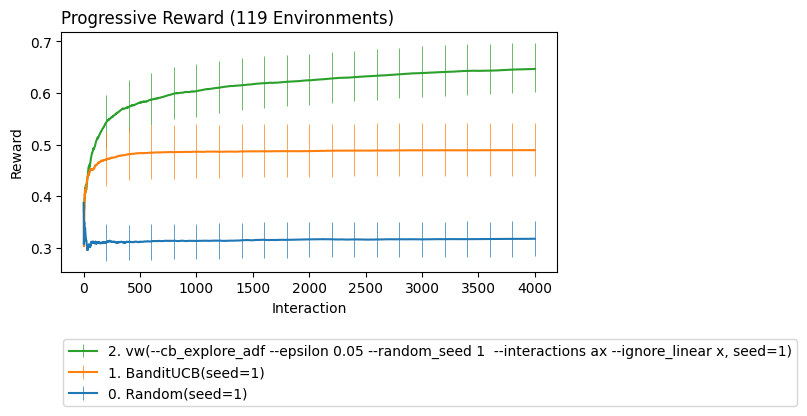

In [5]:
cb.Result.from_save('real-data.log.gz').plot_learners(err='bs')